In [1]:
import matplotlib.pyplot as plt
import csv
import re
import numpy as np
import pandas as pd
import nltk
import time
from IPython.display import display

# Data Cleaning

In [2]:
%cd

/home/ubuntu


I used a corpus online of over 1.5 million tweets for my dataset. Since I didn't have the highest of processing power, I decided to create a parameter to collect a certain amount of tweets for my test and training set.

In [3]:
def getTweetData(numTweets, numTestTweets):
    sentiment = []
    tweet = []
    with open('nbs/data/twitter/Sentiment-Analysis-Dataset.csv') as text:
        for line in text:
            row = line.split(',')
            sentiment.append(row[1])
            tweet.append(row[3])
        
    del sentiment[0]
    del tweet[0]
    testSentiment = sentiment[numTweets+1:numTweets+numTestTweets+1]
    testTweet = tweet[numTweets+1:numTweets+numTestTweets+1]
    sentiment = sentiment[:numTweets]
    tweet = tweet[:numTweets]
    
    #print len(sentiment)
    #print len(tweet)
    
    return sentiment, tweet, testSentiment, testTweet

Here, I clean all the individual texts in the tweets that I have collected. This function goes through every tweet and goes through every word and converts it to lower case, removes any username and/or links, removes additional white spaces, and replaces hashtags with its word.

In [4]:
def cleanTweet(tweet):
    for i in range(0, len(tweet) - 1):
        #lower case and to string
        tweet[i] = str(tweet[i]).lower()
        #links to URL
        tweet[i] = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet[i])
        #username to AT_USER
        tweet[i] = re.sub('@[^\s]+','AT_USER',tweet[i])
        #Remove white spaces
        tweet[i] = re.sub('[\s]+', ' ', tweet[i])
        #replace #word with word
        tweet[i] = re.sub(r'#([^\s]+)', r'\1', tweet[i])
        #trim
        tweet[i] = tweet[i].strip('\'"')
    return tweet

This function gets a list of all the "stop words" that may be present in the collected tweets. These stop words are words that are known to imply no effect on the sentiment value of the tweet.

In [6]:
def getStopWordList(fileName):
    stopWords = []
    stopWords.append('AT_USER')
    stopWords.append('URL')
   
    StopWordFile = open(fileName, 'r')
    line = StopWordFile.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = StopWordFile.readline()
    StopWordFile.close()
    return stopWords

This function gets a separate list of the words present in each individual tweet with the exception of the stop words.

In [7]:
def getFeatureVector(tweet, stopWords):
    featureVector = []
    words = str(tweet).split()
    for word in words:
        word = word.strip('\'"?,.')
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word)
        if(word in stopWords or val is None):
            continue
        else:
            featureVector.append(word.lower())
            
    return featureVector

After we have a separated list of each feature vector of feature words for each tweet, I combined all of the unique feature words present in every feature vector in our training and test set.

In [8]:
def getFeatureList(numTweets, numTestTweets):
    featureList = []
    full_tweets = []
    full_test_tweets = []

    sentiment, tweet, testSentiment, testTweet = getTweetData(numTweets, numTestTweets)
    clean_tweet = cleanTweet(tweet)
    clean_test_tweet = cleanTweet(testTweet)
    stopWords = getStopWordList('nbs/data/twitter/stopwords.txt')
    for i in range(0, len(clean_tweet) - 1):
        featureVector = getFeatureVector(clean_tweet[i], stopWords)
        featureList.extend(featureVector)
        full_tweets.append((featureVector, sentiment[i]))
    for i in range(0, len(clean_test_tweet) - 1):
        featureVector = getFeatureVector(clean_test_tweet[i], stopWords)
        featureList.extend(featureVector)
        full_test_tweets.append((featureVector, testSentiment[i]))
    featureList = list(set(featureList))
    return featureList, full_tweets, full_test_tweets, sentiment, testSentiment, clean_tweet, clean_test_tweet, stopWords

Finally, in order to create a valid input to our classifiers, we need to create a final list for each tweet of which feature words are or are not present in the tweet. Every feature word in the feature list will be present as either true or false depending on its appearance in the tweet.

In [5]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in featureList:
        features['contains(%s)' % word] = (word in tweet_words)
    return features

Now that I had the input structures, I decided to run an efficiency test on both the classifieres I'm going to use: Naive Bayes Classifier and Maximum Entropy Classifier. For this run, I decided to test the run time and accuracy for a training set between 1000 to 5000 tweets, with a test set of 1000 tweets.

In [24]:
startTweets = 1000
endTweets = 5000
jumpTweets = 1000
numTestTweets = 1000
run_time_tweets = np.zeros(((endTweets/jumpTweets),5))


for numTweets in xrange(startTweets, endTweets + 1, jumpTweets):

    featureList, full_tweets, full_test_tweets, sentiment, testSentiment, clean_tweet, clean_test_tweet, stopWords = getFeatureList(numTweets, numTestTweets)
    training_set = nltk.classify.util.apply_features(extract_features, full_tweets)
    testing_set = nltk.classify.util.apply_features(extract_features, full_test_tweets)
    run_time_tweets[(numTweets-startTweets)/jumpTweets][0] = numTweets
    
    start_time = time.time()
    NBClassifier = nltk.NaiveBayesClassifier.train(training_set)
    end_time = time.time() - start_time   
    run_time_tweets[(numTweets-startTweets)/jumpTweets][1] = end_time
    
    start_time = time.time()
    MEClassifier = nltk.classify.maxent.MaxentClassifier.train(training_set, 'GIS', trace = 3, encoding = None, labels = None,
                                                               gaussian_prior_sigma = 0, max_iter = 1)
    end_time = time.time() - start_time
    run_time_tweets[(numTweets-startTweets)/jumpTweets][2] = end_time
    
    run_time_tweets[(numTweets-startTweets)/jumpTweets][3] = round(nltk.classify.accuracy(NBClassifier, testing_set) * 100, 4)
    run_time_tweets[(numTweets-startTweets)/jumpTweets][4] = round(nltk.classify.accuracy(MEClassifier, testing_set) * 100, 4)
   
    print(run_time_tweets[(numTweets-startTweets)/jumpTweets][:])
    
    #tweet_frame = pd.DataFrame(data = (num_data for num_data in run_time_tweets[:][0]), columns = 'numTweets')
    #tweet_frame['runTime'] = (time_data for time_data in run_time_tweets[:][1])

#display(tweet_frame)

  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.330
         Final          -0.58389        0.670
[ 1000.             5.73080587    89.84243894    64.0641        72.3724    ]
  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.304
         Final          -0.54958        0.696
[ 2000.            15.36026406   238.91165495    71.1712        72.7728    ]
  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.294
         Final          -0.53592        0.706
[ 3000.            29.80183601   357.46104813    74.0741        77.0771    ]
  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
 

1-Column: Number of tweets in training set
2-Column: Run time of Naive Bayes Classifier
3-Column: Run time of Maximum Entropy Classifier
4-Column: Accuracy of Naive Bayes Classifier
5-Column: Accuracy of Maximum Entropy Classifier

As you can see from the results, the NBC gradually increased in terms of run time while the MEC skyrocketed to almost 10 times longer than the run time of the NBC. Relating to the NBC having a much better run time stat, its accuracy measurements deemed to be pretty consistent over all training sets while the MEC varied heavily. As a result, I decided that the efficiency of the NBC would prove to be greater than that of the MEC in training and testing larger datasets.

In [56]:
#run_time_tweets.shape
#run_time_tweets
run_time_tweetsREMAKE = [[1000, 5.7308, 89.8424, 64.0641, 72.3724],
                         [2000, 15.3602, 238.9116, 71.1712, 72.7728],
                         [3000, 29.8018, 357.4610, 74.0741, 77.0771],
                         [4000, 56.5688, 884.0608, 67.968, 66.5666],
                         [5000, 88.7822, 1299.2444, 68.5686, 52.6527]]

In [75]:
run_time_tweetsREMAKE

[[1000, 5.7308, 89.8424, 64.0641, 72.3724],
 [2000, 15.3602, 238.9116, 71.1712, 72.7728],
 [3000, 29.8018, 357.461, 74.0741, 77.0771],
 [4000, 56.5688, 884.0608, 67.968, 66.5666],
 [5000, 88.7822, 1299.2444, 68.5686, 52.6527]]

In [82]:
run_timeAccuracy = pd.DataFrame(data = [remake[0] for remake in run_time_tweetsREMAKE], columns = ['numTweets'])
run_timeAccuracy['NBruntime'] = [remake[1] for remake in run_time_tweetsREMAKE]
run_timeAccuracy['MEruntime'] = [remake[2] for remake in run_time_tweetsREMAKE]
run_timeAccuracy['NBaccuracy'] = [remake[3] for remake in run_time_tweetsREMAKE]
run_timeAccuracy['MEaccuracy'] = [remake[4] for remake in run_time_tweetsREMAKE]

In [83]:
display(run_timeAccuracy)

,numTweets,NBruntime,MEruntime,NBaccuracy,MEaccuracy
0,1000,5.7308,89.8424,64.0641,72.3724
1,2000,15.3602,238.9116,71.1712,72.7728
2,3000,29.8018,357.4610,74.0741,77.0771
3,4000,56.5688,884.0608,67.9680,66.5666
4,5000,88.7822,1299.2444,68.5686,52.6527


In [88]:
NBtimetweets = pd.Series(data = run_timeAccuracy['NBruntime'].values, index = run_timeAccuracy['numTweets'])
MEtimetweets = pd.Series(data = run_timeAccuracy['MEruntime'].values, index = run_timeAccuracy['numTweets'])

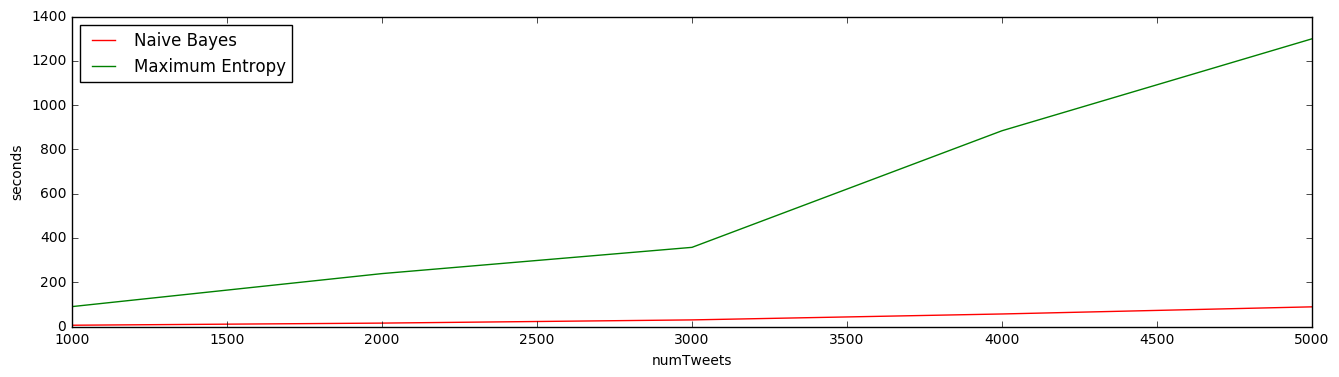

In [99]:
NBtimetweets.plot(figsize = (16, 4), color = 'r', label = 'Naive Bayes', legend = True)
MEtimetweets.plot(figsize = (16, 4), color = 'g', label = 'Maximum Entropy', legend = True)
plt.ylabel('seconds')
plt.show()

# Training on large dataset tweets

Now that I've decided on which classifier to use for my larger datasets, I tested the NBC on a training set of 10000 and test set of 1000.

In [11]:
run_time_tweets = np.zeros((1,4))
numTweets = 10000
numTestTweets = 1000

featureList, full_tweets, full_test_tweets, sentiment, testSentiment, clean_tweet, clean_test_tweet, stopWords = getFeatureList(numTweets, numTestTweets)
training_set = nltk.classify.util.apply_features(extract_features, full_tweets)
testing_set = nltk.classify.util.apply_features(extract_features, full_test_tweets)
run_time_tweets[0][0] = numTweets
    
start_time = time.time()
NBClassifier = nltk.NaiveBayesClassifier.train(training_set)
end_time = time.time() - start_time
run_time_tweets[0][1] = end_time

start_time = time.time()
run_time_tweets[0][2] = round(nltk.classify.accuracy(NBClassifier, testing_set) * 100, 4)
end_time = time.time() - start_time
run_time_tweets[0][3] = end_time
   
print(run_time_tweets[0][:])

[ 10000.            291.65515089     62.4625         84.01360416]


This ended up coming out with a 291.66 second training time with a 62.46% accuracy. The accuracy for the test set took 84.01 seconds to run through.

Now I decided to run a bigger training set of 50000 and a test set of 5000.

In [12]:
run_time_tweets = np.zeros((1,4))
numTweets = 50000
numTestTweets = 5000

featureList, full_tweets, full_test_tweets, sentiment, testSentiment, clean_tweet, clean_test_tweet, stopWords = getFeatureList(numTweets, numTestTweets)
training_set = nltk.classify.util.apply_features(extract_features, full_tweets)
testing_set = nltk.classify.util.apply_features(extract_features, full_test_tweets)
run_time_tweets[0][0] = numTweets
    
start_time = time.time()
NBClassifier = nltk.NaiveBayesClassifier.train(training_set)
end_time = time.time() - start_time
run_time_tweets[0][1] = end_time

start_time = time.time()
run_time_tweets[0][2] = round(nltk.classify.accuracy(NBClassifier, testing_set) * 100, 4)
end_time = time.time() - start_time
run_time_tweets[0][3] = end_time
   
print(run_time_tweets[0][:])

[ 50000.           4325.19606209     70.3341       1228.3966279 ]


This results in a training time of 4325.2 seconds with an accuracy of 70.33% accuracy, which is much better than the 10000 tweet training set. The test set took 1228.4 seconds to run through.

In [13]:
import pickle
f = open('nbs/data/twitter/NBClassifier.pickle', 'wb')
pickle.dump(NBClassifier, f)
f.close()

In [50]:
import pickle
f = open('nbs/data/twitter/NBClassifier.pickle', 'rb')
NBClassifierBitcoin = pickle.load(f)
f.close()

Now that I've trained our own tweet sentiment classifier on a 50000 tweet training dataset, we can check the most influential feature words and their concurrent values. A 0:1 indicates a negative sentiment score while a 1:0 indicates a positive sentiment score.

In [74]:
NBClassifierBitcoin.show_most_informative_features(10)

Most Informative Features
        contains(bummed) = True                0 : 1      =     30.7 : 1.0
     contains(cancelled) = True                0 : 1      =     25.3 : 1.0
           contains(sad) = True                0 : 1      =     22.9 : 1.0
   contains(musicmonday) = True                1 : 0      =     20.4 : 1.0
  contains(followfriday) = True                1 : 0      =     18.1 : 1.0
         contains(sucks) = True                0 : 1      =     16.6 : 1.0
         contains(upset) = True                0 : 1      =     15.4 : 1.0
         contains(awful) = True                0 : 1      =     15.2 : 1.0
     contains(depressed) = True                0 : 1      =     15.2 : 1.0
contains(congratulations) = True                1 : 0      =     15.1 : 1.0


In [17]:
NBClassifier.most_informative_features(10)

[('contains(bummed)', True),
 ('contains(cancelled)', True),
 ('contains(sad)', True),
 ('contains(musicmonday)', True),
 ('contains(followfriday)', True),
 ('contains(sucks)', True),
 ('contains(upset)', True),
 ('contains(awful)', True),
 ('contains(depressed)', True),
 ('contains(congratulations)', True)]

# Pseudo-labeling for Bitcoin

In [75]:
len(bitcoinFeatureList)

29204

Now that I've made a general classifier for general tweets, I need to finetune the classifier to suit more specifically, bitcoin tweets. The process is very similar to that of the general tweets, however we need to create several new inputs/outputs to the existing inputs/outputs.

This function like earlier, will set up our base inputs from the bitcoin tweets I collected from the bitcoin api, and will perform a method called pseudo-labeling, which takes unlabeled inputs such as bitcoin tweets, and use a classifier that was already made to create a sentiment output to attach to it. Now that the input tweets have their relative output sentiments, I can retrain my classifier on these bitcoin tweets to further improve the classifier.

In [125]:
def getBitcoinTweetData(path):
    sentiment = []
    tweet = []
    with open(path) as text:
        for line in text:
            #row = line.split(',')
            tweet.append(line)            
            
    clean_bitcoin_tweet = cleanTweet(tweet)
    for i in range(0, len(clean_bitcoin_tweet)):
        sentiment.append(NBClassifierBitcoin.classify(extract_features(getFeatureVector(clean_bitcoin_tweet[i], stopWords))))

    return sentiment, clean_bitcoin_tweet

In [21]:
bitcoinFeatureList = []
bitcoinFeatureList = featureList

This function gets the feature list of all the feature words in the bitcoin tweets.

In [129]:
def getBitcoinFeatureList(path, bitcoinFeatureList):
    full_tweets_bitcoin = []

    sentiment, clean_bitcoin_tweet = getBitcoinTweetData(path)
    
    stopWords = getStopWordList('nbs/data/twitter/stopwords.txt')
    for i in range(0, len(clean_bitcoin_tweet)):
        featureVector = getFeatureVector(clean_bitcoin_tweet[i], stopWords)
        bitcoinFeatureList.extend(featureVector)
        full_tweets_bitcoin.append((featureVector, sentiment[i]))
    bitcoinFeatureList = list(set(bitcoinFeatureList))
    return bitcoinFeatureList, full_tweets_bitcoin, sentiment, clean_bitcoin_tweet, stopWords

Now that I've set up the specific bitcoin functions I need, I started training our already present classifier on a training set of 4479 bitcoin tweets.

In [130]:
run_time_tweets = np.zeros((1,4))

bitcoinFeatureList, full_tweets_bitcoin, sentiment, clean_bitcoin_tweet, stopWords = getBitcoinFeatureList('nbs/data/twitter/30m.csv', bitcoinFeatureList)
training_set = nltk.classify.util.apply_features(extract_features, full_tweets_bitcoin)
run_time_tweets[0][0] = len(clean_bitcoin_tweet)

start_time = time.time()
NBClassifierBitcoin.train(training_set)
end_time = time.time() - start_time
run_time_tweets[0][1] = end_time

start_time = time.time()
run_time_tweets[0][2] = round(nltk.classify.accuracy(NBClassifierBitcoin, testing_set) * 100, 4)
end_time = time.time() - start_time
run_time_tweets[0][3] = end_time

print(run_time_tweets[0][:])

[ 4479.           522.44309187    70.3341      1393.73794317]


In [131]:
import pickle
f = open('nbs/data/twitter/NBClassifierBitcoin.pickle', 'wb')
pickle.dump(NBClassifierBitcoin, f)
f.close()

In [132]:
NBClassifierBitcoin.show_most_informative_features(10)

Most Informative Features
        contains(bummed) = True                0 : 1      =     30.7 : 1.0
     contains(cancelled) = True                0 : 1      =     25.3 : 1.0
           contains(sad) = True                0 : 1      =     22.9 : 1.0
   contains(musicmonday) = True                1 : 0      =     20.4 : 1.0
  contains(followfriday) = True                1 : 0      =     18.1 : 1.0
         contains(sucks) = True                0 : 1      =     16.6 : 1.0
         contains(upset) = True                0 : 1      =     15.4 : 1.0
         contains(awful) = True                0 : 1      =     15.2 : 1.0
     contains(depressed) = True                0 : 1      =     15.2 : 1.0
contains(congratulations) = True                1 : 0      =     15.1 : 1.0


This function uses the bitcoin classifier to test on more bitcoin tweets along with the collective bitcoin tweets summation of sentiment over time.

In [138]:
def bitcoinSentimentSummation(path):
    sentiment_summation = [0]
    sentiment, clean_bitcoin_tweet = getBitcoinTweetData(path)
    sentiment_value = 0
    for i in range(0, len(clean_bitcoin_tweet)):
        if sentiment[i] == "1":
            sentiment_value = 1
            sentiment_summation.append(sentiment_summation[i] + sentiment_value)
        elif sentiment[i] == "0":
            sentiment_value = -1
            sentiment_summation.append(sentiment_summation[i] + sentiment_value)
    return sentiment, clean_bitcoin_tweet, sentiment_summation

In [139]:
sentiment, clean_bitcoin_tweet, sentiment_summation = bitcoinSentimentSummation('nbs/data/twitter/2h.csv')

In [140]:
len(sentiment)

11463

In [141]:
len(clean_bitcoin_tweet)

11463

In [142]:
len(sentiment_summation)

11464

In [149]:
tweet_sentiment_frame = pd.DataFrame(clean_bitcoin_tweet)

In [151]:
tweet_sentiment_frame['sentiment'] = sentiment

In [158]:
display(tweet_sentiment_frame[:10])

,0,sentiment
0,﻿rt AT_USER AT_USER there are only 21 million ...,1
1,virtual currency: the bitcoin guide howtominec...,1
2,rt AT_USER bitcoin rising above dollar!\nhttps...,1
3,rt AT_USER i know the world is obsessed with t...,1
4,rt AT_USER what you thing about platform? \n\n...,0
5,meet the world's most powerful bitcoin backers...,1
6,"rt AT_USER bitcoin giveaway 2: as promised, we...",0
7,join over 1.000.000 people with the world\u201...,1
8,rt AT_USER bitcoin rising above dollar!\nhttps...,1
9,rt AT_USER weed man only accepting bitcoin now,1


In [159]:
tweet_sentiment_summation_frame = pd.DataFrame(sentiment_summation)

In [161]:
tweet_sentiment_frame.to_csv('nbs/data/twitter/tweet_sentiment_frame')

In [162]:
tweet_sentiment_summation_frame.to_csv('nbs/data/twitter/tweet_sentiment_summation_frame')